# Derivative of a GP

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/Crown421/GPDiffEq.jl/blob/main/examples/derivativegp/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/derivativegp/).*

The derivative of a GP is also a GP, as differentiation is a linear operators. In this example, we show how to use of the `DerivativeGP` and how to easily generate it from a known GP.

## Setup

In [1]:
using GPDiffEq
using Plots

## The toy model
We generate data for our model

In [2]:
σ_n = 3e-2
x = collect(range(-3, 3; length=10))
y = sin.(x) + σ_n * randn(length(x))

10-element Vector{Float64}:
 -0.11872203372103089
 -0.6730310769771524
 -1.0463821815318202
 -0.9044484046183134
 -0.30048954380611104
  0.3445995595253466
  0.8535042143297841
  0.9845139079961506
  0.7706020959089741
  0.11556359322207585

which looks as follows

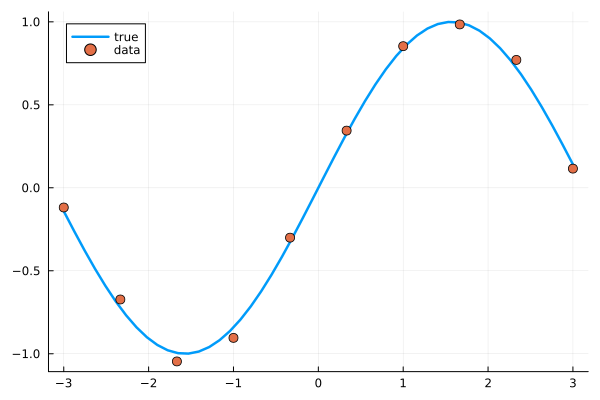

In [3]:
x_plot = collect(range(-3, 3; length=50))

plot(x_plot, sin.(x_plot); label="true", linewidth=2.5)
scatter!(x, y; label="data", markersize=5)
plot!(; legend=:topleft) #hide

# Define a GP

We'll use a simple GP with a `ZeroMean` and `GaussianKernel`, condition it on our data

In [4]:
kernel = GaussianKernel()
f = GP(kernel)
fx = f(x, σ_n^2)

f_post = posterior(fx, y)

AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.SqExponentialKernel{Distances.Euclidean}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, Vector{Float64}, Vector{Float64}}}}(AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.SqExponentialKernel{Distances.Euclidean}}(AbstractGPs.ZeroMean{Float64}(), Squared Exponential Kernel (metric = Distances.Euclidean(0.0))), (α = [1.1989394745524529, -2.577470474518011, 3.540834104144446, -6.748861657709722, 8.252549641474504, -9.34955729850158, 10.05213914532617, -8.302572142202681, 6.70578204431202, -2.9610908820810384], C = LinearAlgebra.Cholesky{Float64, Matrix{Float64}}([1.0004498987955368 0.8003773141272065 … 6.655367228157499e-7 1.5223130876467006e-8; 0.8007374029168073 0.6002467451228027 … 3.0207225222272073e-5 1.0889719997540142e-6; … ; 6.658361469857302e-7 1.8664469113520537e-5 … 0.3482835414112316 0.6956902200185071; 1.522997974471263e

and plot the posterior. Note that this GP completely untrained, no hyperparameters have been defined.

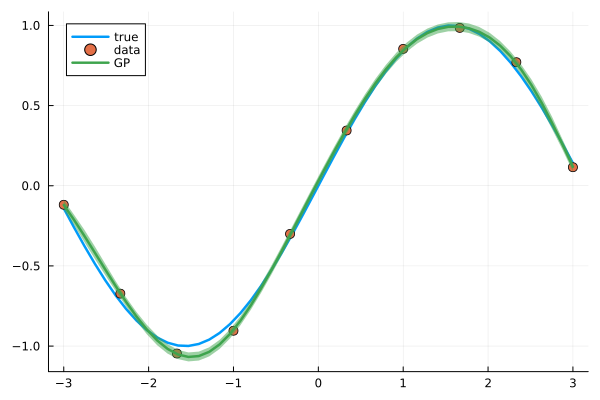

In [5]:
plot(x_plot, sin.(x_plot); label="true", linewidth=2.5)
scatter!(x, y; label="data", markersize=5)
plot!(
    x_plot,
    mean(f_post, x_plot);
    ribbons=sqrt.(var(f_post, x_plot)),
    label="GP",
    linewidth=2.5,
)
plot!(; legend=:topleft) #hide

## Derivative of a GP
Now we can very easily generate the derivate of this GP

In [6]:
df_post = differentiate(f_post)

AbstractGPs.PosteriorGP{GPDiffEq.DerivativeGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.SqExponentialKernel{Distances.Euclidean}}, AbstractGPs.ZeroMean{Float64}, GPDiffEq.DerivativeKernelCollection{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, GPDiffEq.FirstComponentDerivativeKernel{GPDiffEq.var"#d10#12"{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}, KernelFunctions.SqExponentialKernel{Distances.Euclidean}}, GPDiffEq.SecondComponentDerivativeKernel{GPDiffEq.var"#d01#15"{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}, KernelFunctions.SqExponentialKernel{Distances.Euclidean}}, GPDiffEq.BothComponentDerivativeKernel{GPDiffEq.var"#d11#18"{KernelFunctions.SqExponentialKernel{Distances.Euclidean}}, KernelFunctions.SqExponentialKernel{Distances.Euclidean}}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, Vector{Float64}, Vector{Float64}}}}(GPDiffEq.DerivativeGP{AbstractGPs.GP{Abstrac

and plot the new posterior. As we know, the derivative of `sin` is `cos`, so we can check the differentiated GP.

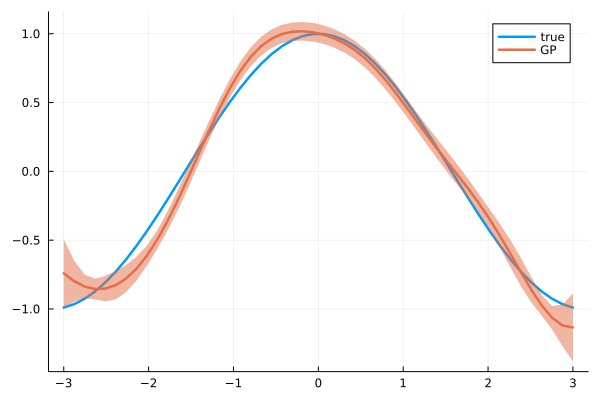

In [7]:
plot(x_plot, cos.(x_plot); label="true", linewidth=2.5)
plot!(
    x_plot,
    mean(df_post, x_plot);
    ribbons=sqrt.(var(df_post, x_plot)),
    label="GP",
    linewidth=2.5,
)

As we saw above, the original GP was slighly off from the true function. This is reflected and amplified in the derivative as well.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*